In [1]:
!pip install joblib
!pip install pandas==0.20.2

In [1]:
import google.cloud.storage as gcs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import joblib
import seaborn as sns
from datetime import datetime as dt
from sklearn.metrics import roc_curve, auc, f1_score, average_precision_score, precision_recall_curve, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
matplotlib.use('Agg')
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
palette = sns.color_palette("Set2", 10)
sns.set_palette(palette)
modelnames = ['7', '14', '21', '28', '35', '42', '49', '56']

font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)
sns.set_style('whitegrid')

## Observation Window

In [3]:
client = gcs.Client('user-lifecycle')
bucket = gcs.Bucket(client, 'helder')
dsnames = ['7_30d', '14_30d', '21_30d', '28_30d', '35_30d', '42_30d', '49_30d', '56_30d']

models = {'lstm': {'name':'LSTM'}, 'rf': {'name':'Random Forest'}, 'lr': {'name':'Logistic Regression'}}
for model, metrics in models.items():
  metrics['prec_recs'] = []
  metrics['pr_aucs'] = []
  metrics['f1s'] = []
  metrics['confusions'] = []
  metrics['roc_aucs'] =  []
  metrics['fpr_tprs'] = []
  metrics['cvs'] = []
  metrics['th_metrics'] = []
  
  for dsname in dsnames:
    blob = gcs.Blob(name='churnr/obs_window/{}/{}/y_test_true_pred.gz'.format(dsname, model), bucket=bucket)
    predpath = '/tmp/{}_y_test_true_pred.gz'.format(model)
    cvpath = '/tmp/{}_cv_results.csv'.format(model)
    with open(predpath, 'wb') as f:
        blob.download_to_file(f)
    blob = gcs.Blob(name='churnr/obs_window/{}/{}/cv_results.csv'.format(dsname, model), bucket=bucket)
    with open(cvpath, 'wb') as f:
        blob.download_to_file(f)

    y_trpred = joblib.load(predpath)
    y_true = y_trpred[:,0]
    y_pred = y_trpred[:,1]
    y_true_ret = 1.0 - y_true 
    y_pred_ret = 1.0 - y_pred

    # calculate PR AUC
    prec, rec, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)
    pr_auc_ret = average_precision_score(y_true_ret, y_pred_ret)

    # calculate some metrics by thresholding to 0.5, maybe it would be smarter to use on of the thresholds
    #   returned by precision_recall_curve()
    y_pred_th = np.array([0.0 if i <= 0.5 else 1.0 for i in y_pred])
    f1 = f1_score(y_true, y_pred_th)  
    prec_th, rec_th, fbeta_th, supp_th = precision_recall_fscore_support(y_true, y_pred_th)

    # calculate the confusion matrix
    cfm = confusion_matrix(y_true, y_pred_th)

    # calculate ROC curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # load CV results
    cv = pd.read_csv(cvpath)

    metrics['pr_aucs'].append(pr_auc)
    metrics['prec_recs'].append((prec, rec))  
    metrics['f1s'].append(f1)
    metrics['confusions'].append(cfm)
    metrics['roc_aucs'].append(roc_auc)
    metrics['fpr_tprs'].append((fpr, tpr))
    metrics['cvs'].append(cv)
    metrics['th_metrics'].append((prec_th, rec_th, fbeta_th, (pr_auc_ret, pr_auc)))

### Precision-Recall Curves

Copying file://prc_obs_window.pdf [Content-Type=application/pdf]...
/ [1 files][684.8 KiB/684.8 KiB]                                                
Operation completed over 1 objects/684.8 KiB.                                    


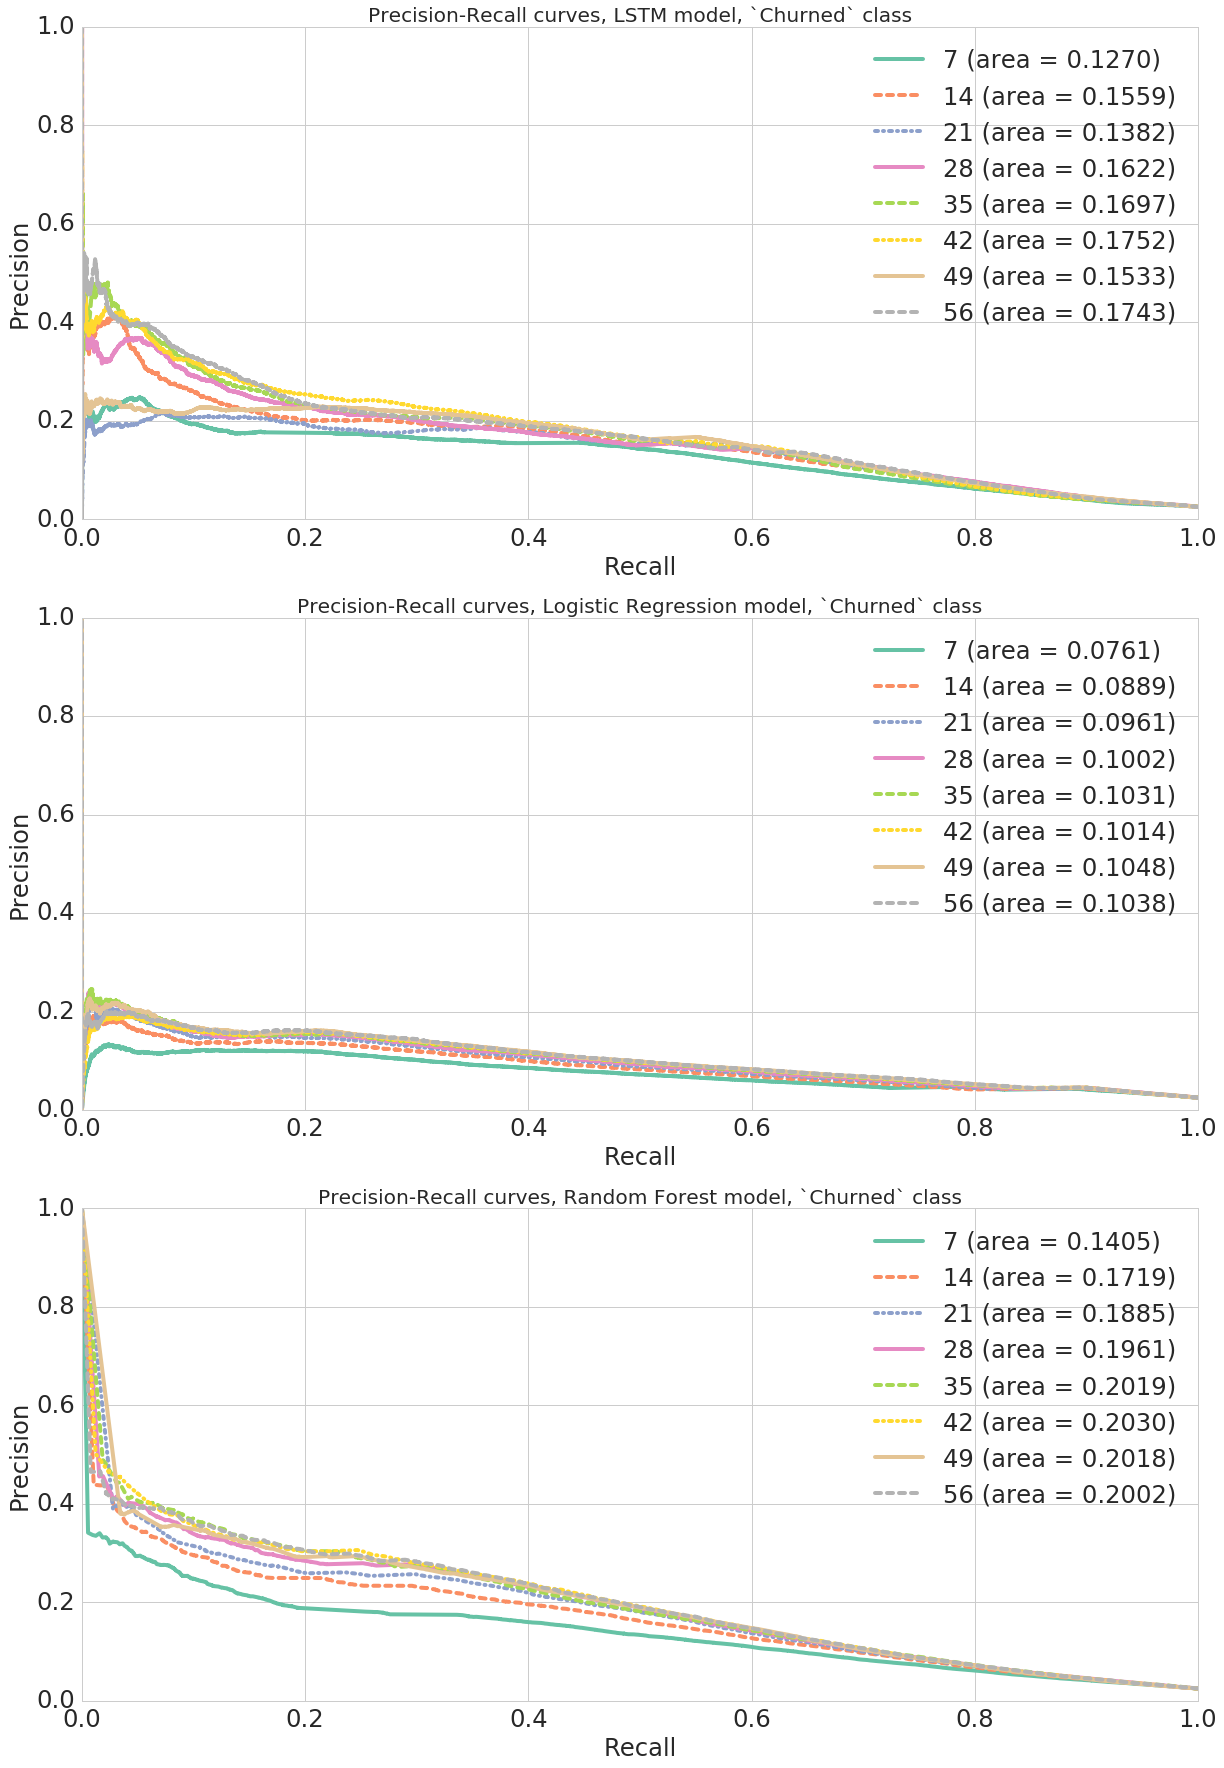

In [98]:
fig, axs = plt.subplots(nrows=3, figsize=(20,30))

for ax, model in zip(axs, models.keys()):
  metrics = models[model]

  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.0])
  ax.set_xlabel('Recall', fontsize='xx-large')
  ax.set_ylabel('Precision', fontsize='xx-large')
  ax.set_title('Precision-Recall curves, {} model, `Churned` class'.format(models[model]['name'], fontsize='xx-large'))
  
  linestyles = ['-', '--', '-.']*len(metrics['prec_recs'])  
  for prec_rec, pr_auc, dsname, f1, ls in zip(metrics['prec_recs'], metrics['pr_aucs'], dsnames, metrics['f1s'], linestyles):
    prec = prec_rec[0]
    rec = prec_rec[1]
    ax.plot(rec, prec, linewidth=4.0, linestyle=ls, dash_capstyle='round', label='{0} (area = {1:.4f})'.format(dsname.split('_')[0], pr_auc))
  
  ax.tick_params(labelsize='xx-large')
  ax.legend(fontsize='xx-large')
  
#plt.savefig('prc_obs_window.pdf', bbox_inches='tight')
#!gsutil cp 'prc_obs_window.pdf' 'gs://helder/churnr/plots/prc_obs_window.pdf'

### ROC Curves

Copying file://roc_obs_window.pdf [Content-Type=application/pdf]...
-
Operation completed over 1 objects/582.5 KiB.                                    


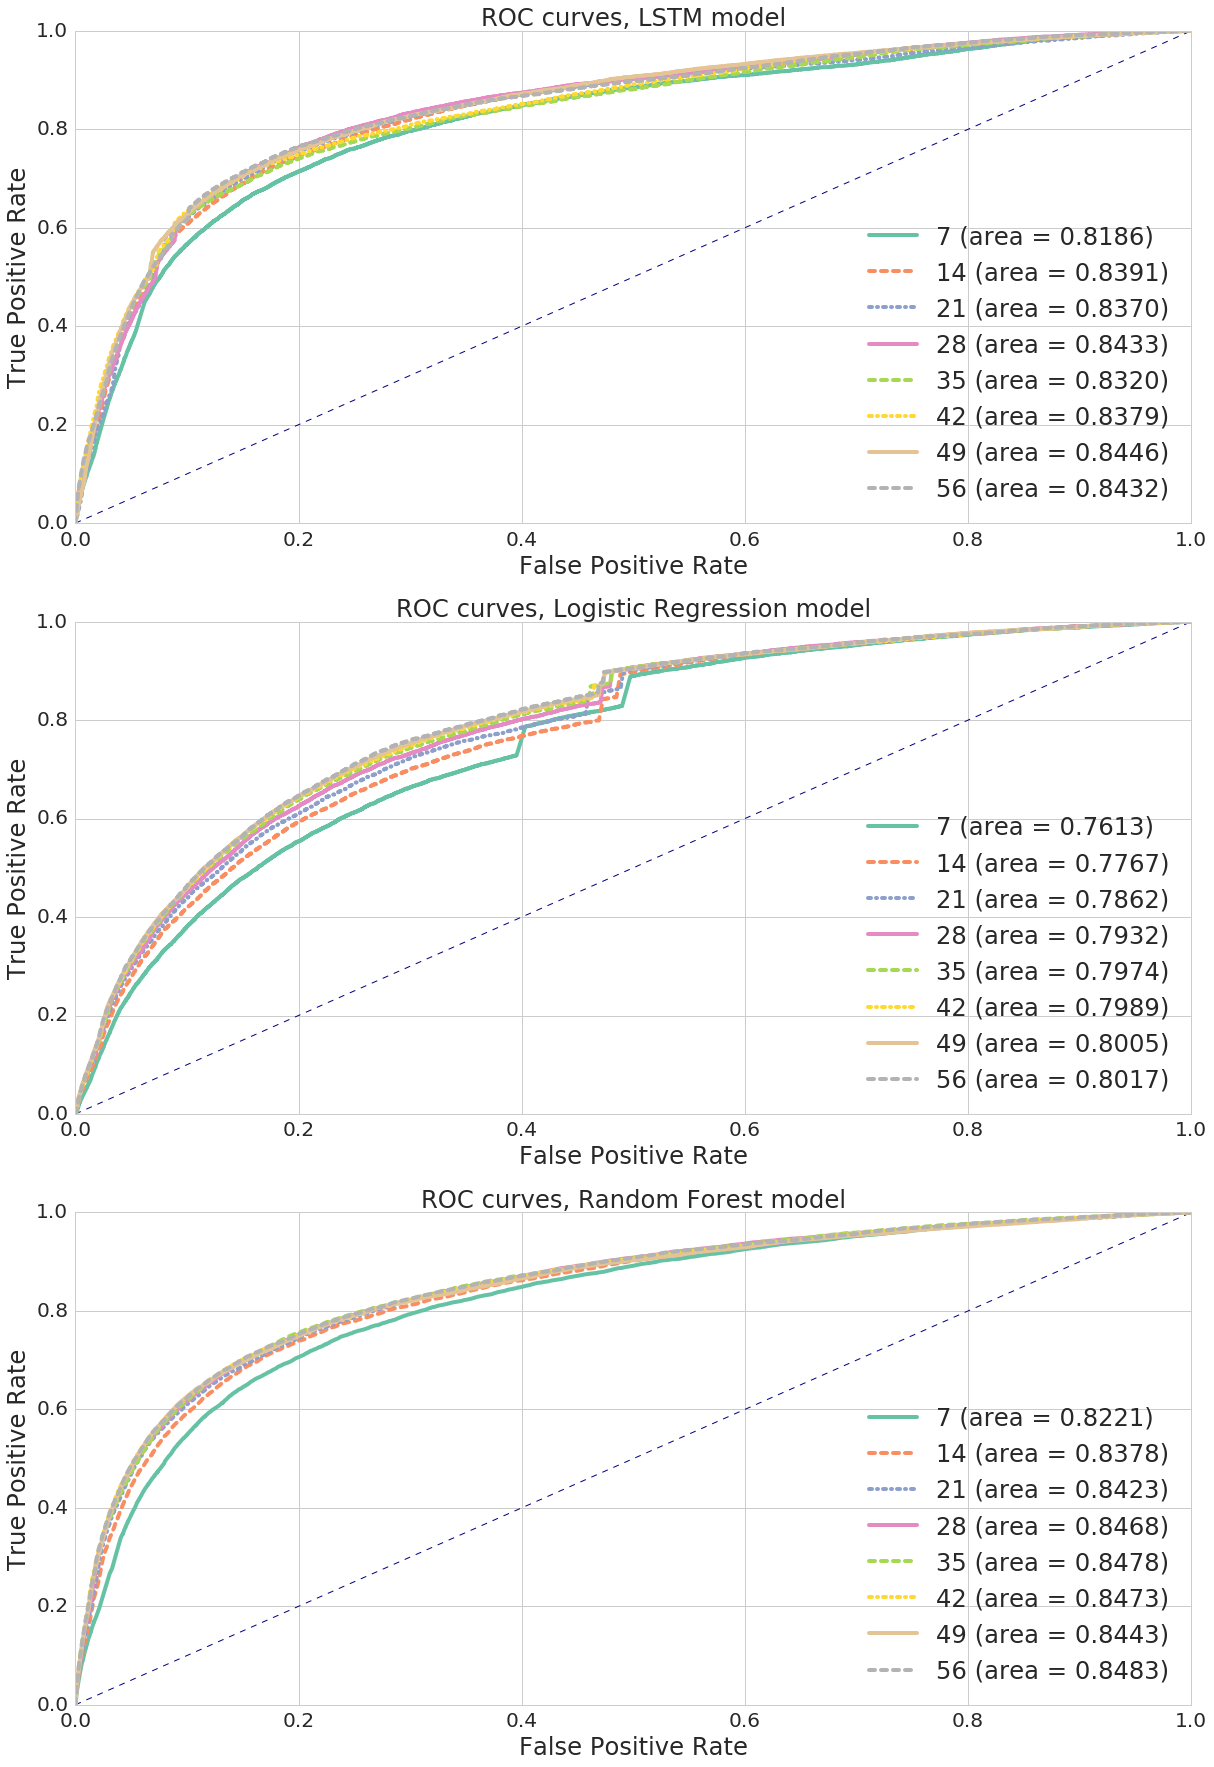

In [100]:
fig, axs = plt.subplots(nrows=3, figsize=(20,30))

for ax, model in zip(axs, models.keys()):
  metrics = models[model]

  ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.0])
  ax.set_xlabel('False Positive Rate', fontsize='xx-large')
  ax.set_ylabel('True Positive Rate', fontsize='xx-large')
  ax.set_title('ROC curves, {} model'.format(models[model]['name']), fontsize='xx-large')

  linestyles = ['-', '--', '-.']*len(metrics['fpr_tprs'])  
  for fpr_tpr, roc_auc, label, ls in zip(metrics['fpr_tprs'], metrics['roc_aucs'], dsnames, linestyles):
    fpr = fpr_tpr[0]
    tpr = fpr_tpr[1]
    ax.plot(fpr, tpr, linewidth=4.0, linestyle=ls, dash_capstyle='round', label='{0} (area = {1:.4f})'.format(label.split('_')[0], roc_auc))

  ax.legend(fontsize='xx-large', loc='best')
  ax.tick_params(labelsize='x-large')
  
#plt.savefig('roc_obs_window.pdf', bbox_inches='tight')
#!gsutil cp 'roc_obs_window.pdf' 'gs://helder/churnr/plots/roc_obs_window.pdf'

### Overall scores

In [5]:
dfs_models = []
for model, metrics in models.items():
  dfs = []
  for metric, dsname in zip(metrics['th_metrics'], dsnames):
    vals = {'Precision': metric[0], 'Recall': metric[1], 'F1-Score': metric[2], 'PR AUC': metric[3]}
    df = pd.DataFrame(vals, index=pd.Index(['Retained','Churned'], name='Label'))
    dfs.append(df)
  dfs = pd.concat(dfs, keys=[n.split('_')[0] for n in dsnames], names=['Days'])
  dfs_models.append(dfs)
dfs_models = pd.concat(dfs_models, keys=[n['name'] for n in models.values()], names=['Models'])
#print(dfs_models.to_latex(multirow=True))
dfs_models

F1-Score    PR AUC  Precision    Recall
Models              Days Label                                            
LSTM                7    Retained  0.895413  0.992923   0.990665  0.816872
                         Churned   0.155974  0.126967   0.087826  0.696106
                    14   Retained  0.886632  0.993870   0.991997  0.801501
                         Churned   0.155449  0.155895   0.086782  0.744706
                    21   Retained  0.923889  0.993570   0.990672  0.865541
                         Churned   0.194156  0.138192   0.113294  0.678247
                    28   Retained  0.907956  0.994128   0.991705  0.837250
                         Churned   0.177579  0.162224   0.101209  0.723529
                    35   Retained  0.893332  0.993526   0.991655  0.812749
                         Churned   0.160036  0.169727   0.089869  0.729970
                    42   Retained  0.899900  0.993773   0.991808  0.823580
                         Churned   0.168215  0.175214   0.095036  0.731434
                    49   Retained  0.934375  0.994084   0.990261  0.884461
                         Churned   0.211187  0.153296   0.125830  0.656582
                    56   Retained  0.898539  0.994353   0.992256  0.820997
                         Churned   0.169514  0.184844   0.095604  0.747048
Logistic Regression 7    Retained  0.813596  0.991253   0.988041  0.691507
                         Churned   0.096696  0.076120   0.052111  0.669562
                    14   Retained  0.825077  0.991869   0.989111  0.707710
                         Churned   0.104656  0.088905   0.056606  0.692398
                    21   Retained  0.826441  0.992184   0.989862  0.709334
                         Churned   0.108152  0.096097   0.058513  0.713184
                    28   Retained  0.829275  0.992497   0.990268  0.713309
                         Churned   0.110912  0.100216   0.060061  0.723236
                    35   Retained  0.830033  0.992643   0.990586  0.714266
                         Churned   0.112509  0.103061   0.060937  0.732019
                    42   Retained  0.829788  0.992641   0.990720  0.713833
                         Churned   0.112941  0.101419   0.061163  0.736020
                    49   Retained  0.834670  0.992744   0.990785  0.721056
                         Churned   0.115351  0.104809   0.062585  0.735240
                    56   Retained  0.830156  0.992835   0.991119  0.714172
                         Churned   0.114696  0.103541   0.062114  0.747341
Random Forest       7    Retained  0.876067  0.993260   0.991120  0.784947
                         Churned   0.141465  0.140472   0.078410  0.722358
                    14   Retained  0.890595  0.993833   0.991612  0.808257
                         Churned   0.157004  0.171877   0.087960  0.730067
                    21   Retained  0.893176  0.993899   0.991700  0.812459
                         Churned   0.160150  0.188480   0.089918  0.731531
                    28   Retained  0.893712  0.994151   0.991931  0.813191
                         Churned   0.162136  0.196100   0.091059  0.738850
                    35   Retained  0.898663  0.994214   0.991843  0.821487
                         Churned   0.167019  0.201898   0.094242  0.733288
                    42   Retained  0.898192  0.994117   0.991803  0.820728
                         Churned   0.166227  0.202974   0.093756  0.732214
                    49   Retained  0.900939  0.993919   0.991547  0.825504
                         Churned   0.167726  0.201751   0.094882  0.722163
                    56   Retained  0.895238  0.994219   0.991906  0.815740
                         Churned   0.163607  0.196442   0.092014  0.737191

### F1-scores for different observation window sizes and models

(0.0, 0.4)

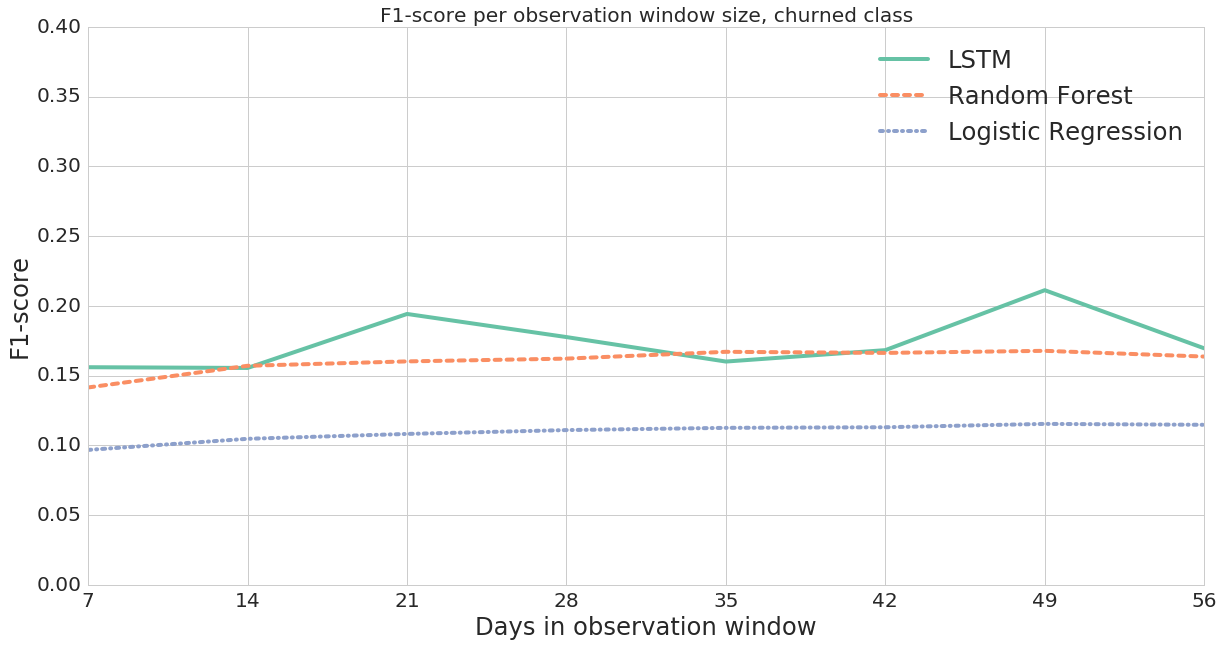

In [8]:
fig, ax = plt.subplots(nrows=1, figsize=(20,10))

x = list(range(len(modelnames)))

ax.set_title('F1-score per observation window size, churned class')
ax.set_xlabel('Days in observation window', fontsize='xx-large')
ax.set_ylabel('F1-score', fontsize='xx-large')

linestyles = ['-', '--', '-.']
for modeltype, ls in zip(['LSTM', 'Random Forest', 'Logistic Regression'], linestyles):
  vals = list(dfs_models.query("Label == 'Churned' and Models == '{}'".format(modeltype))['F1-Score'])
  ax.plot(x, vals, label=modeltype, linewidth=4.0, linestyle=ls, dash_capstyle='round')

ax.legend(fontsize='xx-large', loc='best')
ax.tick_params(labelsize='x-large')

ax.xaxis.set_ticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
ax.set_xticklabels(['7', '14', '21', '28', '35', '42', '49', '56'])

ax.set_ylim(0.0,0.4)

#plt.savefig('line_obs_window.pdf', bbox_inches='tight')
#!gsutil cp 'line_obs_window.pdf' 'gs://helder/churnr/plots/line_obs_window.pdf'

(0.6, 1.0)

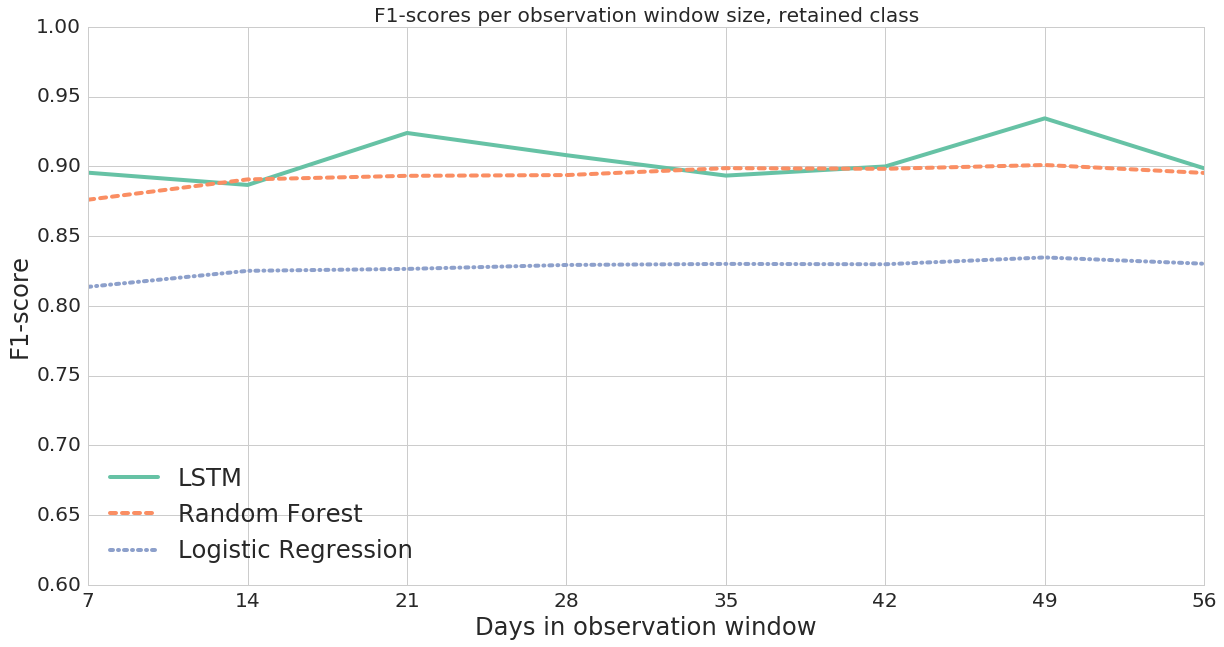

In [9]:
fig, ax = plt.subplots(nrows=1, figsize=(20,10))

x = list(range(len(modelnames)))

ax.set_title('F1-scores per observation window size, retained class')
ax.set_xlabel('Days in observation window', fontsize='xx-large')
ax.set_ylabel('F1-score', fontsize='xx-large')

linestyles = ['-', '--', '-.']
for modeltype, ls in zip(['LSTM', 'Random Forest', 'Logistic Regression'], linestyles):
  vals = list(dfs_models.query("Label == 'Retained' and Models == '{}'".format(modeltype))['F1-Score'])
  ax.plot(x, vals, label=modeltype, linewidth=4.0, linestyle=ls, dash_capstyle='round')

ax.legend(fontsize='xx-large', loc='best')
ax.tick_params(labelsize='x-large')
ax.xaxis.set_ticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
ax.set_xticklabels(['7', '14', '21', '28', '35', '42', '49', '56'])

ax.set_ylim(0.6,1.0)

#plt.savefig('line_obs_window_retained.pdf', bbox_inches='tight')
#!gsutil cp 'line_obs_window_retained.pdf' 'gs://helder/churnr/plots/line_obs_window_retained.pdf'